## New code

In [68]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from molvs import Standardizer
from lib.descriptors.cdk import ECFPCalc, ECFPID
from lib.rdkit import V
from rdkit.Chem.PandasTools import LoadSDF
import numpy as np
import pandas as pd

### Load data

In [55]:
data_path = "ba_assets/data_for_models/data_threshold_all_filled_0.5_all_masters/training_chembl+manual/%s.sdf"
targets = [
    "BCRP",
    "BCRP-S",
    "BSEP",
    "MATE1",
    "MDR1",
    "MDR1-S",
    "MRP2-S",
    "MRP3",
    "MRP3-S",
    "OATP1B1",
    "OATP1B3",
    "OCT1",
    "OCT2",
]

In [63]:
grouped_mols = {target: LoadSDF(data_path % target).ROMol for target in targets}

In [72]:
all_mols = pd.concat(grouped_mols.values())

### Etc.

In [80]:
pipeline = Pipeline(
    steps=[
        ("standardizer", FunctionTransformer(V(Standardizer().standardize))),
        ("descriptors", FunctionTransformer(V(ECFPCalc(ECFPID.ECFP4)))),
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2)),
        ("pca_scaler", MinMaxScaler()),
        (
            "lof",
            LocalOutlierFactor(
                n_neighbors=5, novelty=True, contamination=0.1, metric="euclidean"
            ),
        ),
    ]
)

In [81]:
pipeline.fit(all_mols)

[21:06:19] Can't kekulize mol.  Unkekulized atoms: 0 2 3 5 6 7 10 11 14


Pipeline(steps=[('standardizer',
                 SingleFunctionTransformer(func=<__main__.SingleFunctionTransformer.Vectored object at 0x7fd86d21e6c0>)),
                ('descriptors',
                 SingleFunctionTransformer(func=<__main__.SingleFunctionTransformer.Vectored object at 0x7fd86d21f8c0>)),
                ('scaler', MinMaxScaler()), ('pca', PCA(n_components=2)),
                ('pca_scaler', MinMaxScaler()),
                ('lof',
                 LocalOutlierFactor(contamination=0.1, metric='euclidean',
                                    n_neighbors=5, novelty=True))])

In [88]:
def make_grid(mols):
    pipeline[-1].fit(pipeline[:-1].transform(mols))

    xx, yy = np.meshgrid(np.linspace(-0.2, 1.2, 100), np.linspace(-0.2, 1.2, 100))
    ZZ = pipeline[-1].decision_function(np.c_[xx.ravel(), yy.ravel()])
    ZZ = ZZ.reshape(xx.shape)

    return ZZ

In [83]:
import json
from pathlib import Path

In [89]:
Path("grid.json").write_text(
    json.dumps(
        [
            {
                "grid": np.flip(make_grid(mols), axis=0).flatten().tolist(),
                "name": name,
            }
            for name, mols in grouped_mols.items()
        ]
    )
)

[21:19:23] Can't kekulize mol.  Unkekulized atoms: 0 2 3 5 6 7 10 11 14


2678974

In [40]:
from matplotlib import pyplot as plt

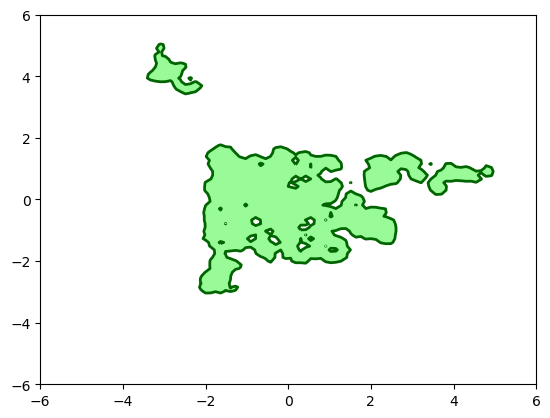

In [86]:
plt.figure()
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="darkgreen")
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palegreen")

## Old code

In [16]:
from dataclasses import dataclass, asdict
from typing import Optional

In [17]:
@dataclass
class VegaGrid:
    values: list[int]
    scale: int
    width: int
    height: int
    x1: Optional[int] = None
    y1: Optional[int] = None
    x2: Optional[int] = None
    y2: Optional[int] = None

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [ ]:
def train_lof(domain_data, descriptors="ecfp4"):
    iso_map = make_pipeline(MinMaxScaler(), PCA(n_components=2))
    model = LocalOutlierFactor(
        n_neighbors=5, novelty=True, contamination=0.1, metric="euclidean"
    )

    descs = domain_data["ROMol"].apply(
        lambda romol: pd.Series(calculate_descriptors(romol, descriptors))
    )
    train_iso = iso_map.fit_transform(descs)
    model.fit(train_iso)

    return model, iso_map

In [ ]:
def lof_matrices_calc(domain_data, descriptors="ecfp4"):
    model, pca = train_lof(domain_data, descriptors)
    xx, yy = np.meshgrid(np.linspace(-6, 6, 100), np.linspace(-6, 6, 100))
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    return pd.Series({"grid": Z, "lof": model, "pca": pca})

In [ ]:
def calc_descriptors_for(data, descriptors="ecfp4"):
    return data["ROMol"].apply(
        lambda romol: pd.Series(calculate_descriptors(romol, descriptors))
    )

In [ ]:
def is_in_domain(domain_data, test_data, descriptors="ecfp4"):
    model, iso_map = train_lof(domain_data, descriptors)

    test_descs = test_data["ROMol"].apply(
        lambda romol: pd.Series(calculate_descriptors(romol, descriptors))
    )

    tests = []
    test_iso = iso_map.transform(test_descs)

    iso_ad_pred = []
    for tp in test_iso:
        iso_ad_pred.append(model.predict([tp])[0])
        tests.append([tp[0], tp[1]])

    return test_data.assign(outlier=np.asarray(iso_ad_pred) < 0)

In [ ]:
lof_matrices = data_all.groupby(["target", "chembl_or_manual", "train_or_test"]).apply(
    lambda frame: lof_matrices_calc(frame)
)
lof_matrices = pd.DataFrame(lof_matrices)

In [ ]:
lof_matrices_for_json = lof_matrices["grid"].apply(
    lambda grid: pd.Series(
        {
            "width": 100,
            "heigth": 100,
            "values": grid.ravel(),
        }
    )
)

lof_matrices_for_json.reset_index().to_json(
    output_directory.joinpath("lof-grid-matrix.json"), orient="records"
)

In [ ]:
target = "MDR1"

plt.style.use("ggplot")

plt.figure()
xx, yy = np.meshgrid(np.linspace(-6, 6, 100), np.linspace(-6, 6, 100))
pca = lof_matrices.loc[pd.IndexSlice[target, "chembl", "train"], "pca"]

Z = lof_matrices.loc[pd.IndexSlice[target, "chembl", "train"], "grid"]
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="darkred")
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")
descs = calc_descriptors_for(test_data_chembl[test_data_chembl["target"] == target])
tests = pca.transform(descs)
plt.scatter(tests[:, 0], tests[:, 1], c="red", edgecolors="black", zorder=4)

Z2 = lof_matrices.loc[pd.IndexSlice[target, "manual", "train"], "grid"]
plt.contour(xx, yy, Z2, levels=[0], linewidths=2, colors="blue")
plt.contourf(xx, yy, Z2, levels=[0, Z2.max()], colors="lightblue")
descs = calc_descriptors_for(test_data_manual[test_data_manual["target"] == target])
tests = pca.transform(descs)
plt.scatter(tests[:, 0], tests[:, 1], c="lightblue", edgecolors="k", zorder=3)

In [ ]:
a = is_in_domain(
    train_data_chembl.pipe(lambda d: d[d["target"] == target]),
    train_data_manual.pipe(lambda d: d[d["target"] == target]),
)["outlier"].value_counts()

b = is_in_domain(
    train_data_manual.pipe(lambda d: d[d["target"] == target]),
    train_data_chembl.pipe(lambda d: d[d["target"] == target]),
)["outlier"].value_counts()